# 00 — Exploratory Data Analysis (EDA)

**Goal:** Explore the dataset, understand its structure, inspect image labels, and examine the feature space before applying clustering methods.

This notebook prepares the intuition and context for feature extraction and clustering.


## 1. Imports

We import all the Python libraries needed for EDA

In [2]:
import os
import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import drive
from collections import Counter

## 2. Mounting drive and locating dataset

We mount Google Drive in Colab so we can access the ZIP file containing the PatternMind dataset.

We then define the key paths:

- `ZIP_PATH` → location of the dataset ZIP in Drive  
- `UNZIP_DIR` → directory where the ZIP will be extracted  
- `DATASET_DIR_NAME` → name of the dataset folder inside the ZIP  
- `DATA_ROOT` → full path to the extracted dataset directory

After extraction, we verify that `DATA_ROOT` exists and print its contents to confirm that the dataset has been correctly unzipped and is ready to be processed.


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ZIP_PATH = "/content/drive/MyDrive/patternmind_dataset.zip"
UNZIP_DIR = "/content/patternmind_unzipped"
DATASET_DIR_NAME = "patternmind_dataset"

DATA_ROOT = os.path.join(UNZIP_DIR, DATASET_DIR_NAME)
print("Will use DATA_ROOT:", DATA_ROOT)

Will use DATA_ROOT: /content/patternmind_unzipped/patternmind_dataset


In [5]:
if not os.path.isdir(DATA_ROOT):
    os.makedirs(UNZIP_DIR, exist_ok=True)
    !unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"
    print("Unzipped dataset.")
else:
    print("Dataset already unzipped.")

Unzipped dataset.


We are listing the contents of the extracted directory to confirm proper extraction.
The dataset root folder can be seen:
System folders like __MACOSX (typical from macOS ZIP archives)

In [6]:
print("DATA_ROOT exists:", os.path.isdir(DATA_ROOT))
print("Contents of UNZIP_DIR:", os.listdir(UNZIP_DIR))

DATA_ROOT exists: True
Contents of UNZIP_DIR: ['patternmind_dataset', '__MACOSX']


## 3. Load Dataset and Basic Information

Here we load the dataset and check:
- number of images
- image file structure
- any available labels (optional)
- basic dataset organization


In [7]:
root = DATA_ROOT

folders = [d for d in os.listdir(root)
                 if os.path.isdir(os.path.join(root, d))]

print("Number of class folders:", len(folders))
print("First 20 class folders:", folders[:20])

Number of class folders: 233
First 20 class folders: ['pyramid', 'ostrich', 'ak47', 'radio-telescope', 'billiards', 'swan', 'iris', 'ewer', 'ibis', 'hammock', 'self-propelled-lawn-mower', 'license-plate', 'centipede', 'chopsticks', 'eiffel-tower', 'mattress', 'necktie', 'school-bus', 'snowmobile', 'trilobite']


## 4. Collect All Image Paths

We recursively scan the dataset directory to collect all image file paths.

Supported extensions:
- `.jpg`
- `.jpeg`
- `.png`

This gives us the full list of images used throughout the project.


In [8]:
DATA_DIR = UNZIP_DIR
extensions = ['*.jpg', '*.jpeg', '*.png']
image_paths = []

for ext in extensions:
    image_paths.extend(glob.glob(os.path.join(DATA_DIR, '**', ext), recursive=True))

print("Total images found:", len(image_paths))
image_paths[:5]

Total images found: 25557


['/content/patternmind_unzipped/patternmind_dataset/pyramid/pyramid_01.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/pyramid/pyramid_44.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/pyramid/pyramid_49.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/pyramid/pyramid_02.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/pyramid/pyramid_29.jpg']

## 5. Extract Class Labels from Folder Structure

Each image is stored inside a folder corresponding to its class label.  
We extract the label from the folder name of each file path.

This helps verify dataset organization and class distribution.

We create a DataFrame containing:

- `filepath`  
- `label`  

This structure allows us to compute:
- class distribution  
- number of images  
- empty / missing folders

In [9]:
# folder name = class label
def get_class_from_path(path):
    return os.path.basename(os.path.dirname(path))

labels = [get_class_from_path(p) for p in image_paths]

df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

df.head()

,path,label
0,/content/patternmind_unzipped/patternmind_data...,pyramid
1,/content/patternmind_unzipped/patternmind_data...,pyramid
2,/content/patternmind_unzipped/patternmind_data...,pyramid
3,/content/patternmind_unzipped/patternmind_data...,pyramid
4,/content/patternmind_unzipped/patternmind_data...,pyramid


## 6. Class Distribution

We count how many images appear in each class folder.  

This helps detect:
- class imbalance  
- empty folders  
- incorrectly named folders  


In [10]:
class_counts = df["label"].value_counts().sort_values(ascending=False)

print("Number of classes:", len(class_counts))
class_counts.head(10)


Number of classes: 233


,count
label,
clutter,761
airplanes,720
motorbikes,719
faces-easy,396
t-shirt,330
hammock,257
billiards,251
horse,246
ladder,223


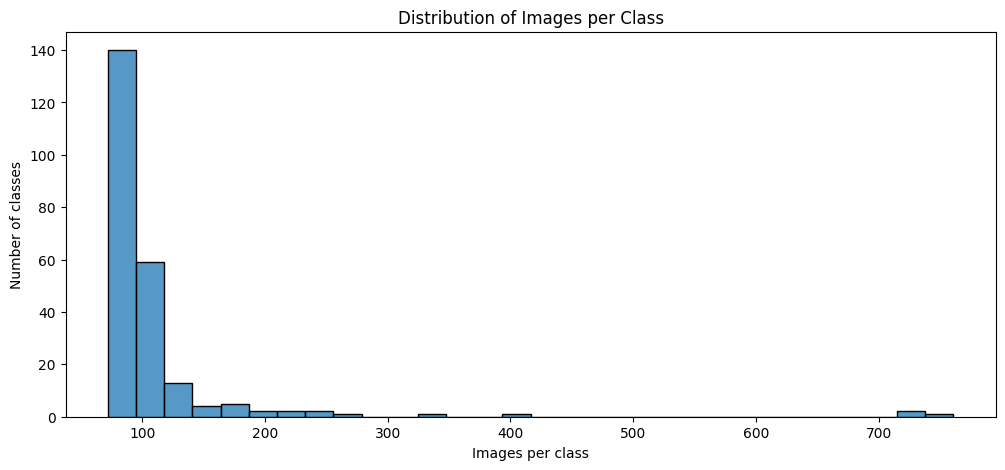

In [11]:
plt.figure(figsize=(12, 5))
sns.histplot(class_counts, bins=30)
plt.title("Distribution of Images per Class")
plt.xlabel("Images per class")
plt.ylabel("Number of classes")
plt.show()

## 7. Checking for empty folders, duplicates, and corrupted images

We perform several quality checks:
- **Empty folders**: identify any class folders with zero images  
- **Duplicate filenames**: check if the same filename appears in multiple folders (which may indicate duplicated or mislabelled images)  
- **Corrupted images**: attempt to open each file with PIL and collect any that fail to load

These checks help ensure that the dataset is clean and suitable for downstream processing.

In [12]:
folder_counts = {}

for cls in folders:
    cls_path = os.path.join(root, cls)
    images = [f for f in os.listdir(cls_path)
              if os.path.isfile(os.path.join(cls_path, f))]
    folder_counts[cls] = len(images)

print("Total folders:", len(folder_counts))
print("Total images:", sum(folder_counts.values()))

Total folders: 233
Total images: 25558


In [13]:
empty_folders = [cls for cls, count in folder_counts.items() if count == 0]
print("Empty folders:", empty_folders if empty_folders else "None")

Empty folders: None


In [14]:
all_files = []

for cls in folders:
    for file in os.listdir(os.path.join(root, cls)):
        if os.path.isfile(os.path.join(root, cls, file)):
            all_files.append(file)

name_counts = Counter(all_files)
duplicates = [name for name, cnt in name_counts.items() if cnt > 1]

print("Duplicate filenames:", len(duplicates))
print("Examples:", duplicates[:234])

Duplicate filenames: 0
Examples: []


In [15]:
bad_files = []

for path in tqdm(image_paths, desc="Checking corrupted images"):
    try:
        img = Image.open(path)
        img.verify()   # verify file integrity
    except Exception:
        bad_files.append(path)

print("Corrupted files found:", len(bad_files))

Checking corrupted images: 100%|██████████| 25557/25557 [00:01<00:00, 14093.55it/s]

Corrupted files found: 0


## 8. File Extensions

We compute the frequency of file extensions (e.g., `.jpg`, `.jpeg`, `.png`) to verify dataset consistency and detect any unexpected image formats.  
This ensures that all images can be processed in later steps without compatibility issues.


In [16]:
exts = df["path"].apply(lambda x: os.path.splitext(x)[1].lower()).value_counts()
exts

,count
path,
.jpg,25557


## 9. Basic Dimension Statistics (Sample of 200 Images)

To understand the variability in image resolutions, we randomly select a sample of 200 images and measure their width and height.  
We then compute basic summary statistics (mean, median, min, max).  

This helps verify:
- whether image sizes are relatively consistent  
- if extreme outliers exist  
- how much resizing will be needed during preprocessing


In [17]:
sample_paths = np.random.choice(image_paths, size=200, replace=False)

widths, heights = [], []

for p in sample_paths:
    try:
        img = Image.open(p)
        w, h = img.size
        widths.append(w)
        heights.append(h)
    except:
        pass

print("Avg width:", np.mean(widths))
print("Avg height:", np.mean(heights))

Avg width: 368.375
Avg height: 327.76


## 10. Building a DataFrame for EDA

We build a pandas DataFrame that stores metadata about each image:

- `filepath` → full path to the image file  
- `class` (or `label`) → class name derived from the folder  
- `filename` → the basename of the file  
- `width`, `height` → image dimensions in pixels (read with PIL)  
- `extension` → file extension (e.g. `.jpg`, `.png`)

This DataFrame allows us to:

- inspect basic statistics  
- detect unusual image sizes  
- check for unexpected file extensions  
- compute class distributions and other aggregates

In [18]:
data = {
    "filepath": [],
    "class": [],
    "filename": [],
    "width": [],
    "height": [],
    "extension": []
}

for cls in folders:
    cls_path = os.path.join(root, cls)

    for file in os.listdir(cls_path):
        file_path = os.path.join(cls_path, file)
        if not os.path.isfile(file_path):
            continue

        ext = file.split(".")[-1].lower()

        try:
            img = Image.open(file_path)
            width, height = img.size
        except:
            width, height = None, None

        data["filepath"].append(file_path)
        data["class"].append(cls)
        data["filename"].append(file)
        data["width"].append(width)
        data["height"].append(height)
        data["extension"].append(ext)

df = pd.DataFrame(data)
df.head()

,filepath,class,filename,width,height,extension
0,/content/patternmind_unzipped/patternmind_data...,pyramid,pyramid_01.jpg,739.0,485.0,jpg
1,/content/patternmind_unzipped/patternmind_data...,pyramid,pyramid_44.jpg,600.0,403.0,jpg
2,/content/patternmind_unzipped/patternmind_data...,pyramid,pyramid_49.jpg,400.0,283.0,jpg
3,/content/patternmind_unzipped/patternmind_data...,pyramid,pyramid_02.jpg,720.0,414.0,jpg
4,/content/patternmind_unzipped/patternmind_data...,pyramid,pyramid_29.jpg,493.0,265.0,jpg


## 11. EDA summary plots

We create simple visual summaries to better understand the dataset:

- A bar plot showing the **number of images per class**, which reveals class balance or imbalance  
- Optional plots or histograms derived from the metadata DataFrame (e.g. image height/width distributions)  

These plots provide a quick visual overview and help spot anomalies, such as extremely small or extremely large images.

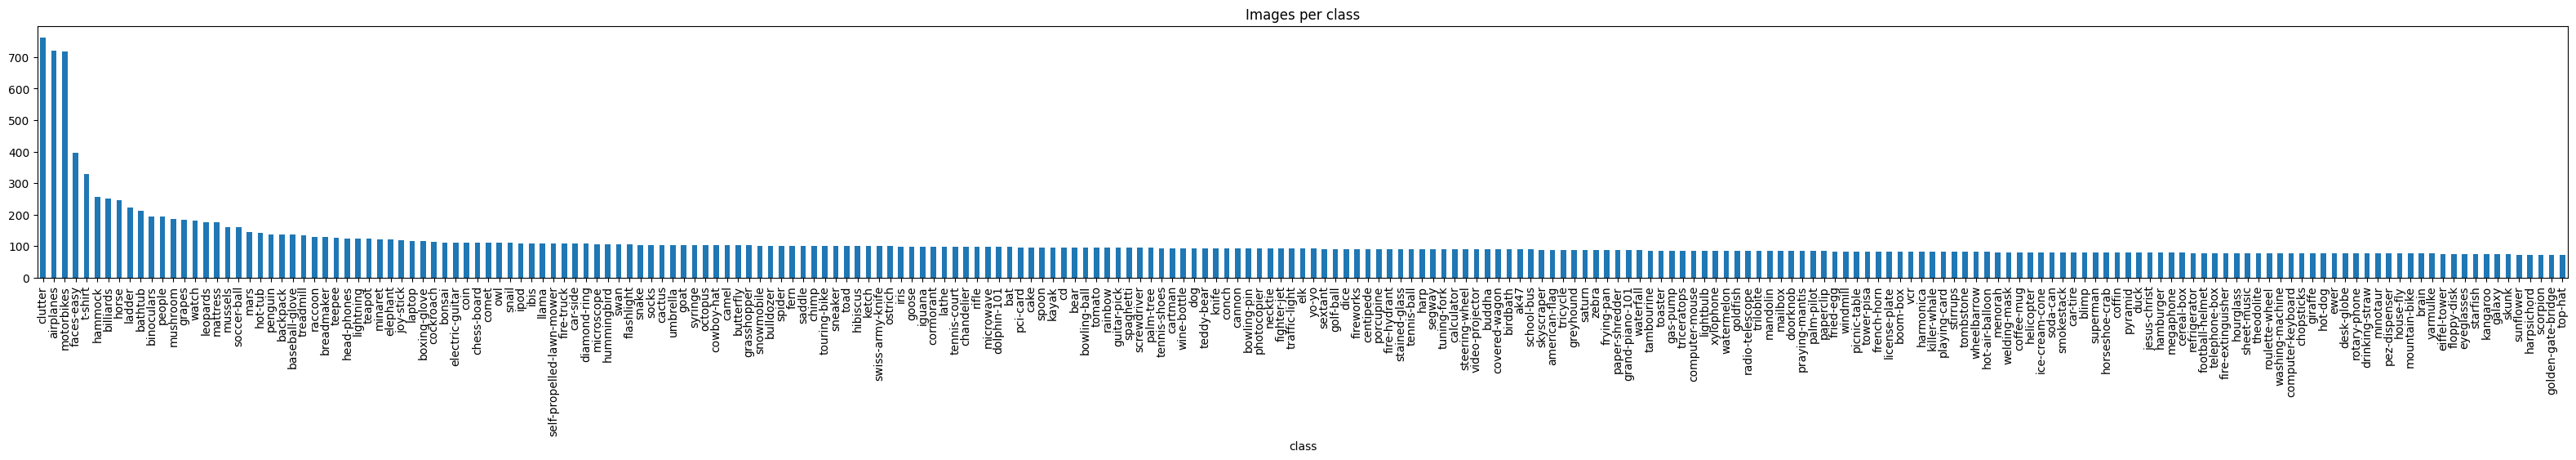

In [19]:
df['class'].value_counts().plot(kind='bar', figsize=(40,4))
plt.title("Images per class")
plt.show()

In [20]:
df[['width','height']].describe()

,width,height
count,25557.000000,25557.000000
mean,371.891810,326.044137
std,229.095197,206.907445
min,100.000000,97.000000
25%,238.000000,200.000000
50%,300.000000,280.000000
75%,442.000000,397.000000
max,7913.000000,7913.000000


## 12. Final summary

At the end of the notebook, we print out a compact textual summary:

- total number of categories (`len(folders)`)  
- total number of images (`sum(folder_counts.values())`)  
- presence (or absence) of empty folders  
- number of corrupted images (`len(bad_files)`)  
- set of file extensions found in the dataset


In [21]:
print("Data set summary:")
print("Total categories:", len(folders))
print("Total images:", sum(folder_counts.values()))
print("Empty folders:", empty_folders if empty_folders else "None")
print("Corrupted images:", len(bad_files))
print("File extensions:", extensions)

Data set summary:
Total categories: 233
Total images: 25558
Empty folders: None
Corrupted images: 0
File extensions: ['*.jpg', '*.jpeg', '*.png']
